In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from functools import partial

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
url = 'root://eosuser.cern.ch/'

In [3]:

f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/{pairing}_bkg_2018_0L/mc/qcd-mg_tree.root'
f_bkg = f_pattern.format(pairing='feynnet-6J')

treekwargs = dict(
            use_gen=False,
            treename='Events',
            normalization='Runs:genEventCount',
        )

bkgtree = Tree(fc.fs.cernbox.glob(f_bkg, with_path=True), **treekwargs)

100%|██████████| 1/1 [00:07<00:00,  7.62s/it]


In [4]:
bkgtree.sample, bkgtree.color

('qcd-mg', 'lightblue')

100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


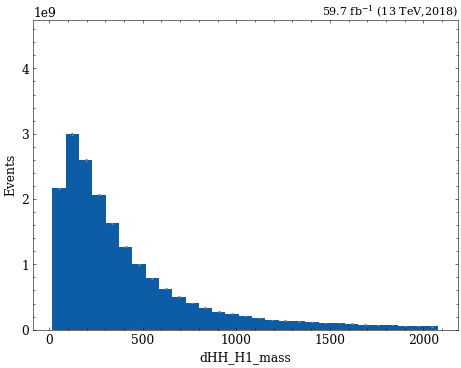

In [11]:
study.quick(
    [bkgtree],
    varlist=['dHH_H1_mass']
)

In [5]:

treekwargs = dict(
            use_gen=False,
            treename='Events',
            normalization=None,
        )

f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/{pairing}_sig_2018_0L/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(pairing='feynnet-6J')
sigtree = Tree( fc.fs.cernbox.glob(f_sig, with_path=True), **treekwargs)

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


In [8]:

sig_xsec_fix = ( 1.0 * (5.824E-01)**2 ) / (1000 * 0.010517)
ObjIter([sigtree]).apply(lambda t : t.reweight(t.genWeight * t.xsecWeight * sig_xsec_fix))

[None]

100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


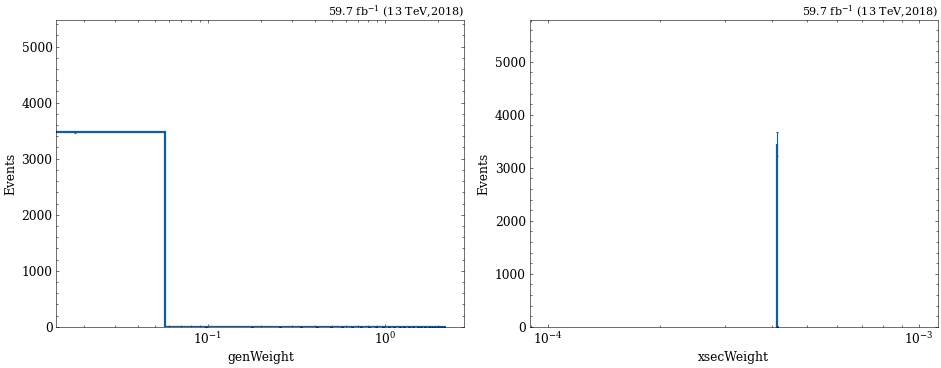

In [9]:
study.quick(
    [sigtree],
    varlist=['genWeight','xsecWeight'],
    logx=True,
)

100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


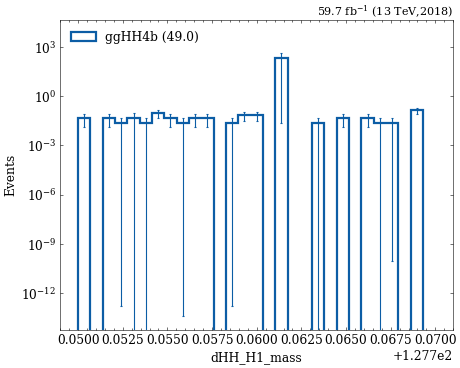

In [32]:
study.quick(
    [sigtree],

    varlist=['dHH_H1_mass'],
    binlist=[(127.75,127.77,30)],
    h_label_stat=lambda h : np.sum(h.raw_counts),
    legend=True,
    log=True,
)

In [34]:
lo,hi = 127.75,127.77
f_mask = lambda t : (t.dHH_H1_mass > lo) & (t.dHH_H1_mass < hi)
mask = f_mask(sigtree)


In [68]:
badid = ak.argmax(sigtree.scale)

In [75]:
sigtree.genWeight

<Array [0.0298, 0.0298, ... 0.0298, 0.0298] type='156574 * float32'>

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 <utils.plotUtils.histogram.Histo at 0x7f6fb754a940>)

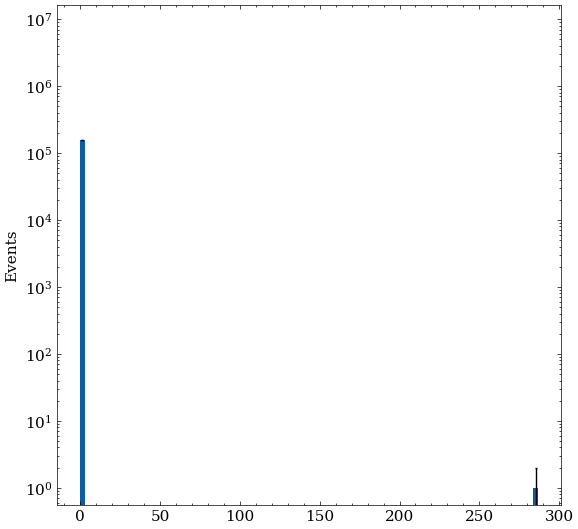

In [74]:
histo_array(sigtree.genWeight, bins=(np.min(sigtree.genWeight), np.max(sigtree.genWeight), 100), log=True)

In [70]:
sigtree.scale[badid], sigtree.genWeight[badid], sigtree.xsecWeight[badid]

(0.0038209776394069195, 286.7820129394531, 0.0004131157184019685)

In [39]:
x = sigtree.dHH_H1_mass[mask]
w = sigtree.scale[mask]

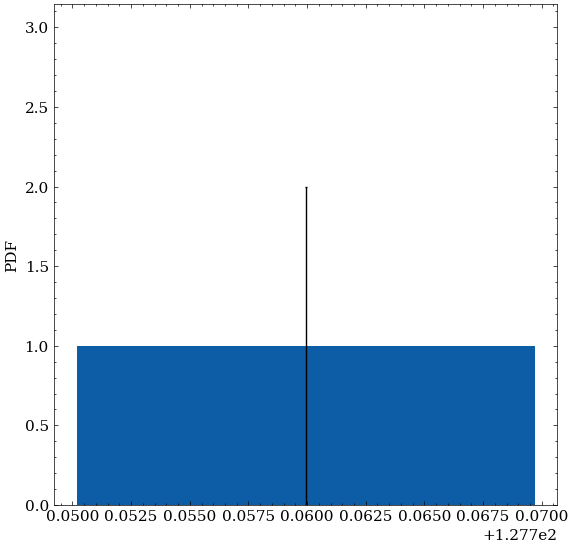

In [51]:
_,_, h = histo_array(x, weights=w, efficiency=True, h_rebin=2)

In [59]:
w_sum = np.sum(abs(w))
w_sum2 = np.sqrt(np.sum(w**2))

In [63]:
np.argmax(w)

5

In [64]:
w[5]

0.0038209776394069195

In [60]:
w_sum, w_sum2

(0.003840013504941453, 0.00382097862727618)

100%|██████████| 1/1 [00:00<00:00, 25.91it/s]


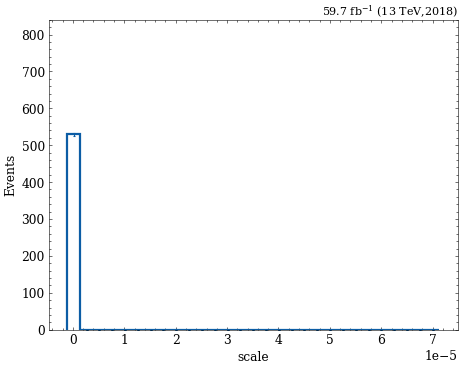

In [14]:
study.quick(
    [sigtree],
    masks=,
    varlist=['scale'],
)

In [31]:

@cache_variable
def n_loose_btag(t):
    nL = t.ak4_h1b1_btag_L + t.ak4_h1b2_btag_L + t.ak4_h2b1_btag_L + t.ak4_h2b2_btag_L
    
    return ak.values_astype(nL, np.int32)
@cache_variable
def n_tight_btag(t):
    nL = t.ak4_h1b1_btag_T + t.ak4_h1b2_btag_T + t.ak4_h2b1_btag_T + t.ak4_h2b2_btag_T
    
    return ak.values_astype(nL, np.int32)
@cache_variable(bins=(0,100,30))
def h_dm(t):
    return np.sqrt( (t.dHH_H1_mass - 125)**2 + (t.dHH_H2_mass - 125)**2 )

@cache_variable(bins=(0,100,30))
def vr_h_dm(t):
    return np.sqrt( (t.dHH_H1_mass - 179)**2 + (t.dHH_H2_mass - 172)**2 )

In [32]:
@cache_variable
def n_loose_t4_btag(t):
    order = ak.argsort(-t.ak4_bdisc, axis=1)
    n_loose = t.ak4_btag_L[order][:,:4]
    return ak.values_astype(ak.sum(n_loose, axis=1), np.int32)

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


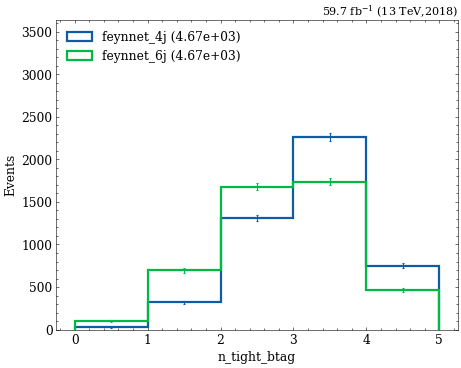

In [33]:
study.quick(
    signal,
    h_color=None,
    varlist=[n_tight_btag],
    legend=True,
)


100%|██████████| 2/2 [00:00<00:00, 14.64it/s]


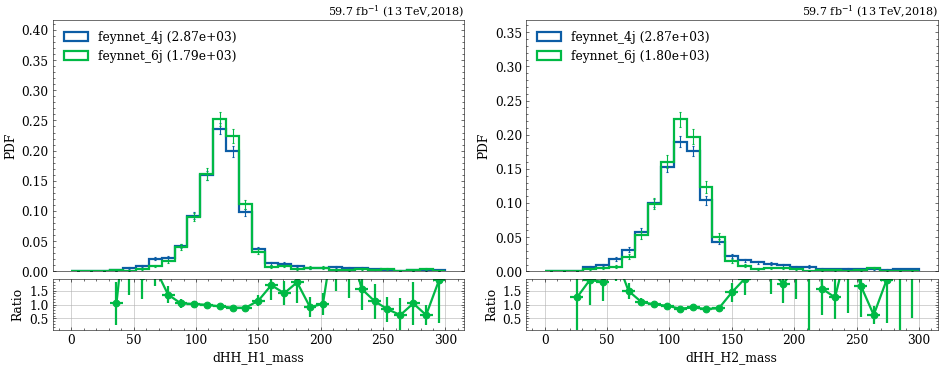

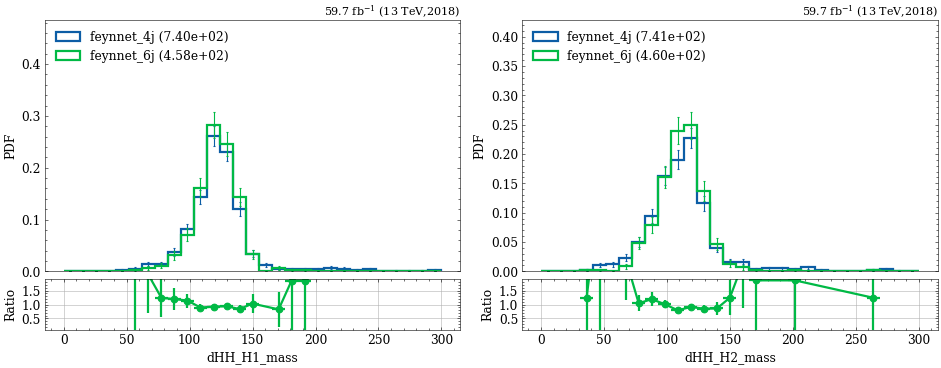

In [34]:
study.quick(
    signal,
    masks=lambda t : n_loose_btag(t) == 4,
    legend=True,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    ratio=True,
    efficiency=True,
)

study.quick(
    signal,
    masks=lambda t : n_tight_btag(t) == 4,
    legend=True,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    ratio=True,
    efficiency=True,
)

100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


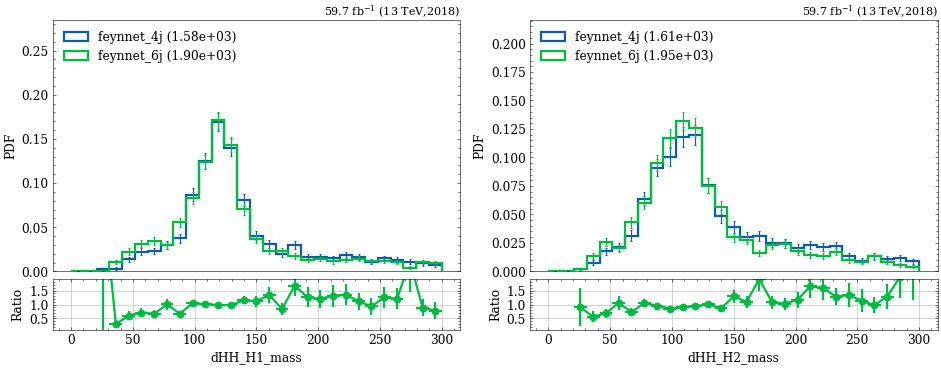

In [29]:
study.quick(
    signal,
    masks=lambda t : n_loose_btag(t) == 3,
    legend=True,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    ratio=True,
    efficiency=True,
)